# CS 109 Final Project
# By: William Chen, Sebastian Chiu, Salena Cui, and Carl Gao
# Buffalo Capital Management
# TF: Lehman Garrison

Website: https://sites.google.com/site/predictingstockmovement

<img src="https://sites.google.com/site/predictingstockmovement/_/rsrc/1386466801198/config/customLogo.gif?revision=3">
<br>

# Overview and Motivation

As long as capital markets have existed, investors and aspiring arbitrageurs alike have strived to gain edges in predicting stock prices. In particular, use of machine-learning techniques and quantitative analysis to make stock price predictions has become increasingly popular with time. Success, however, can be hard to come by; predicting financial price movements is an extremely difficult task. Nevertheless, the motivation for doing so is constantly present, with lucrative opportunities and insightful outcomes awaiting victors in an ongoing information battle.

Our team wishes to use the Data Science framework we learned in CS 109 to take our chances at predicting stock price movements. Through the Boston Data Festival, we participated in a competition organized by Hack/Reduce and sponsored by DataRobot on November 10. The task of the competition was to take data from the past 9 days of a stock's pricing data and the opening price on the 10th day to predict whether the closing price on the 10th day is greater than or less than the opening price on the 10th day. After experimenting with various singular and stacked models, we eventually were able to devise a model that obtained an AUC of 0.941, which won us 1st place in the competition.

Through this engaging and rewarding experience with predictive stock price modeling, we became very excited about the real-world applications of this kind of model and wanted to go more in depth into our predictive analysis after the competition. Our CS109 final project gave us a structured opportunity to extend our work. We aim to test a variety of models on S&P 500 stocks encompassing a different industries and quantify the success of our models. Such analysis may give Buffalo Capital Management an upper hand in any future investing endeavors!



# Related Work

We were inspired by the successes we've seen in algorithmic trading and computer-assisted stock analysis. Several well-documented effects we've read about online are the momentum effect and regression to the mean. There has been a lot of research conducted about the significance of the momentum effect in stock price prediction. For example, Lee and Swaminathan (2002) studied the relationship between momentum and value trading strategies, while Grinblatt and Moskowitz (2004) examined the effect of consistent positive past returns on the link between past and expected returns. The wealth of research into price momentum made us interested in examining this effect further and seeing how it could be applied to stock price prediction models. 

# Initial Questions

There are a number of questions that we wished to initially address in our project.

1. Given historical data and a stock's pricing data for 9 days and its opening price on the 10th day, how much success can we have in predicting whether the closing price on the 10th day is greater than or less than the opening price on the 10th day?
2. Which classification models will perform the best at assisting us in making predictions used to answer Question 1?
3. Do stacked/blended models (models that utilize some committee to combine predictions made from two or more separate classification models) perform better or worse than individual classification models in making predictions used to answer Question 1?
4. Among the S&P 500 stocks, are there any industries for which the predictions used to answer Question 1 tend to be more or less accurate than the predictions made for other industries?
5. What are some of the differences between the behaviors of our classification models when making predictions used to answer Question 1?

Question 4 was suggested in principle by our TF, Lehman. Question 5 arose when running our models.


# Data

The initial dataset we used was a dataset used by Hack/Reduce at the Boston Data Festival Predictive Modeling Hackathon. The training data consisted of the opening, closing, maximum and minimum prices for 94 stocks over 500 days. The hackathon dataset used stock data from 20 years ago, and we wanted to see how our models would perform on more recent data. We wrote a function that reads in a file with stock tickers, one per row, to create a file of stock price data. We assume that we have a list of the S&P 500 stocks, stored in stocks.csv, that lists each stock ticker, along with the associated company name and industry area. We decide to analyze the S&P 500 stocks in 5 different industry areas.

1. Consumer Discretionary
2. Health Care
3. Information Technology
4. Financials
5. Industrials

Thus, including the historical data set provided to us and these 5 additional data sets, we have 6 total data sets that we choose to analyze.

(The stocks tickers for the historical data set are: AA ABT ABX ADI ADM AET AMD AMR APC AVP AXP BA BAC BAX BBY BK BMC BMY BNI BP CA CAT CI CL COP CVX DD DE DIS DOW EK EMC EMR FNM FRE FRX GE GLW GPS GSK HAL HD HON HPQ HRB IBM IGT JNJ JPM JWN KO KR LLY LOW LTD LUV MCD MDT MMM MO MOT MRK MRO MU MYL NKE NSM NWS OXY PEP PFE PG RSH SLB SLE SLM STJ SYK SYY TGT TJX TMX TXN UN UNH UTX VOD VZ WAG WFC WMB WMT XOM XRX. The stock tickers for the historical data can be found by running the code below that uses the categories in stocks.csv to separate stock tickers to their respective industry classifications.)

What follows is the data scraper we used to generate the datasets we analyzed for this project. 

In [49]:
# Load in packages
from pandas.io.data import DataReader
from datetime import datetime
import numpy as np
import pandas as p
from itertools import chain
import matplotlib.pyplot as plt
import operator
import sys

%matplotlib inline

We assume that we have a list of the S&P 500 stocks, stored in stocks.csv, that lists each stock ticker, along with the associated company name and industry area. We first want to take stocks.csv and create 5 text files that contain the stock tickers of S&P 500 companies in the 5 aforementioned industry areas.

In [ ]:
sp500 = [list(i) for i in np.array(p.read_table('./sp500.csv', sep = ","))]
cons_disc = '\n'.join(i[0] for i in sp500 if i[2] == 'Consumer Discretionary')
healthcare = '\n'.join(i[0] for i in sp500 if i[2] == 'Health Care')
info_tech = '\n'.join(i[0] for i in sp500 if i[2] == 'Information Technology')
financials = '\n'.join(i[0] for i in sp500 if i[2] == 'Financials')
industrials = '\n'.join(i[0] for i in sp500 if i[2] == 'Industrials')
file_names = {'cons_disc.txt':cons_disc, 'healthcare.txt':healthcare, 'info_tech.txt':info_tech, 'financials.txt':financials, 'industrials.txt':industrials}
for file_name in file_names.keys():
    # Uncomment below lines to run code. As we include the data files in the submission, we do not wish to run the code at this time.
    f = open(file_name, 'w')
    # f.write(file_names[file_name])
    f.close()

Now, we want a function that can take in a text file with stock tickers (one per row), and produce our desired dataset. To do this, we assume that we will be using 9 days of data to predict whether the closing price on the 10th day will be greater than or less than the opening price on the 10th day. Our dataset will be composed of approximately 2 years of stock price data. Since we can use a rolling time window to test our data, for any stock ticker, stock price data for $n$ days will produce $n-9$ rows of data.

Our function is given below.

In [ ]:
# Function that reads in file with stock tickers, one per row,
# to create a file of data with stock price data.
# Data includes open, max, min, close and volume.
def get_stock_prices(fname, start, end):
    
    # Function to check if date is valid
    def check_date(date):
        return len(date) == 3 and len(date[0]) == 4 and len(date[1]) == 2 and len(date[2]) == 2
    
    # Load in stock tickers
    tickers = [line.strip() for line in open(fname)]
    
    # Format start and end days and check validity of dates
    start = start.split('-')
    end = end.split('-')
    errors = not (check_date(start) and check_date(end))
    if errors:
        print('Your dates need to be of the form \'YYYY-MM-DD\'!')
        return
    start = datetime(int(start[0]), int(start[1]), int(start[2]))
    end = datetime(int(end[0]), int(end[1]), int(end[2]))
    timelapse = end-start
    if timelapse.days < 14:
        print('You need a date range that exceeds 10 business days!')
        return
    
    # Create data file and return results
    results = []
    for ticker in tickers:
        try: 
            data = np.array(DataReader(ticker, "yahoo", start, end))[::-1]
            data = np.delete(data, np.s_[-1:], 1)
            result = []
            for i in range(10):
                result.append(data[i:(i+data.shape[0]-9),:])
        except:
            pass
        results.append(np.hstack(result))
    return np.vstack(results)

We now produce the datasets for each of our industry areas using the generated stock tickers in from July 1, 2012 to December 5, 2013.

In [ ]:
data_file_names = {'cons_disc.csv':'cons_disc.txt', 'healthcare.csv':'healthcare.txt', 'info_tech.csv':'info_tech.txt', 'financials.csv':'financials.txt', 'industrials.csv':'industrials.txt'}
for data_file_name in data_file_names:
    # Again, as we include data files in our submission, we do not run the below code, but you can uncomment it to run it it you want.
    #data = get_stock_prices(data_file_names[data_file_name], '2012-07-01', '2013-12-05')
    #np.savetxt(data_file_name, data, delimiter=",", header=','.join([str(i) for i in range(1,51)]))

Now we can load in the data and process it into the format that we like. This block of code takes in a csv file, and processes it.

In the case that we are loading in the provided Kaggle data, we break up the window of 500 days of data in a stack of rolling 10 days worth of data. In the case that we are loading in a dataset that we made ourselves, we simply take in the columns that we want, or the 10 opening days and 9 closing days worth of data. In both cases, we normalize each row of the dataset so that all stock prices are expressed as a ratio with the opening on day 1.

We get a X matrix, where the matrix contains rows of stock open and close prices, and a y matrix, where the matrix contains indicators of whether or not the stock went up that day.

In [25]:
################################################################################
# CHOOSE WHICH TRAIN DATASET TO USE
################################################################################

train = np.array(p.read_table('./training.csv', sep = ","))
#train = np.array(p.read_table('./cons_disc.csv', sep = ","))
#train = np.array(p.read_table('./healthcare.csv', sep = ","))
#train = np.array(p.read_table('./info_tech.csv', sep = ","))
#train = np.array(p.read_table('./financials.csv', sep = ","))
#train = np.array(p.read_table('./industrials.csv', sep = ","))

################################################################################
# READ IN THE KAGGLE TRAIN DATA
################################################################################

        
"""
Function
--------
normalize10day

Replaces all min/max/vol data with 0, and divides all stock data\
by the opening price on the first day

Inputs
-------
stocks : (Nexample, Nfeature) array
        data for stocks, with 10 days of OPEN, MIN, MAX, CLOSE, VOL respectively
"""   
def normalize10day(stocks):
    def process_column(i):
        if operator.mod(i, 5) == 1:
            return stocks[:,i] * 0
        if operator.mod(i, 5) == 2:
            return stocks[:,i] * 0
        if operator.mod(i, 5) == 4:
            return stocks[:,i] * 0
            #return np.log(stocks[:,i] + 1)
        else:
            return stocks[:,i] / stocks[:,0]
    n = stocks.shape[0]
    stocks_dat =  np.array([ process_column(i) for i in range(46)]).transpose()
    return stocks_dat

if train.shape[0] == 94: # if we're using the kaggle training data
    n_windows = 490
    windows = range(n_windows)
    
    # we convert the 500 day data into a stack of 10 day data.
    X_windows = [train[:,range(1 + 5*w, 47 + 5*w)] for w in windows]
    X_windows_normalized = [normalize10day(w) for w in X_windows]
    
    X = np.vstack(X_windows_normalized)
    
    # read in the response variable and convert to indicators
    y_stockdata = np.vstack([train[:, [46 + 5*w, 49 + 5*w]] for w in windows])
    y = (y_stockdata[:,1] > y_stockdata[:,0]) + 0
    
################################################################################
# READ IN THE MODERN TRAIN DATA
################################################################################

else:
    # chain.from_iterable is basically a "flatten" function, that takes a list of lists and 
    # converts it to one list
    # columns we want are just the opening and closing prices
    columns_we_want = list(chain.from_iterable([[5 * x, 5 * x + 3] for x in range(10)]))[:-1]
    
    # we get our matrix of open and close prices, and normalize the data such that all data
    # is divided by the opening price on the first day
    X = np.array([l/l[0] for l in train[:, columns_we_want]])
    
    # we make indicators of whether or not the stock went up that day.
    y = (train[:, 48] > train[:, 45]) + 0

# Exploratory Analysis

With the datasets that we are given, we wish to explore several common statistical classifiers in order to investigate the predictive power they may yield on our data set. The models explored were Lasso, Ridge Regression, Random Forest, and Gradient Boosted Trees.  
In addition, we were interested in the performance of stacked models, or models that operated by combining the predictions from two or more different models. As such, we additionally test two models, one that combines Ridge Regression and Random Forest and another that combines all of the models that we output.  
We combine models by taking the predictive output from each model on our training data and running the output through Logistic Regression in order to achieve our final output.

The general philosophy we use in testing our models is to split our dataset into training and test data. For each classifier, we use cross validation techniques to select an optimal tuning parameters when necessary and to evaluate the result predictive accuracy. In this way, we determined which classifier and associated parameters would be best to use. We will observe that our stacked performed better than our individual models, but not by a significant amount.

## Understanding market correction effects

For the purposes of exploratory analysis, we focus first on understanding the background behind what could drive an increase in stock price.  
Although we have the previous 9 days of stock data for any stock that we are learning about, we suspect that not all of this information is necessarily useful for making a predictive model, because of our understanding of efficient markets and momentum effects.  
In particular, in running our models on different subsets of the data, we find that including maximum and minimum prices as well as volumes are not useful in predicting prices. As such, we will only utilize the opening and closing prices.

To understand market correction effects, we also seek to correlate intraday change (open on day 10 divided by close on day 9) and intraday change (close on day 10 divided by open on day 10).  
There is a negative correlation between interday change (ratio between closing and opening price today), and intraday change (ratio between opening price today and closing price yesterday).

This is because markets may overreact to events that happen during closing hours, and then correct themselves. This would explain any negative correlation. The strong correlation gives us a hint that stock market movement up or down is in fact predictable.

The code below produces scatterplots that demonstrate the negative correlation referred to above.

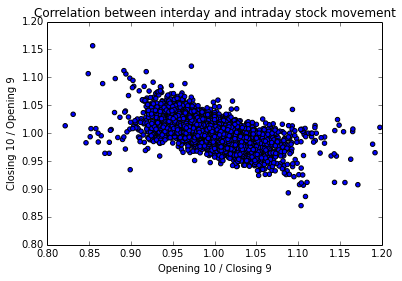

In [15]:
################################################################################
# Please uncomment out the set you want to use as training
################################################################################

train = np.array(p.read_table('./cons_disc.csv', sep = ","))
#train = np.array(p.read_table('./healthcare.csv', sep = ","))
#train = np.array(p.read_table('./info_tech.csv', sep = ","))
#train = np.array(p.read_table('./financials.csv', sep = ","))
#train = np.array(p.read_table('./industrials.csv', sep = ","))

plt.scatter(train[:, 45] / train[:, 43], train[:, 48] / train[:, 45])
plt.xlim((.8,1.2)); plt.ylim((.8,1.2))
plt.xlabel("Opening 10 / Closing 9"); plt.ylabel("Closing 10 / Opening 9")
plt.title("Correlation between interday and intraday stock movement")
plt.show()

Please see the graphs below for a sample of the same correlations (these graphs are created in ggplot2 for presentation for our website and our video).

<img src="http://i.imgur.com/lj0ijgQ.png">

As a result of the above findings, one can certainly make an argument that there are strong market correction effects at play. Hence, it may not make sense that we are using 9 days of opening and closing prices to make predictions if only the last 3 days, for instance, are most pertinent to making a prediction. However, when running our model, we see that including information from all the days of stock prices that we are given does tend to improve the model. As such, we do include the previous 9 days of data in creating our model.

## Selecting the tuning parameters and evaluating our models

We now run our 4 individual models on our 6 different datasets in order to evaluate the performance of the models and select their relevant tuning parameters.

Below, we include two helper functions by Ben Hamner of Kaggle. We use AUC as our cross-validation metric since it has a neat probabilitistic interpration in binary predictions without being sensitive to the relative sizes of the classes.

In [47]:
def tied_rank(x):
    """
    This function is by Ben Hamner and taken from https://github.com/benhamner/Metrics/blob/master/Python/ml_metrics/auc.py

    Computes the tied rank of elements in x.

    This function computes the tied rank of elements in x.

    Parameters
    ----------
    x : list of numbers, numpy array

    Returns
    -------
    score : list of numbers
            The tied rank f each element in x

    """
    sorted_x = sorted(zip(x,range(len(x))))
    r = [0 for k in x]
    cur_val = sorted_x[0][0]
    last_rank = 0
    for i in range(len(sorted_x)):
        if cur_val != sorted_x[i][0]:
            cur_val = sorted_x[i][0]
            for j in range(last_rank, i): 
                r[sorted_x[j][1]] = float(last_rank+1+i)/2.0
            last_rank = i
        if i==len(sorted_x)-1:
            for j in range(last_rank, i+1): 
                r[sorted_x[j][1]] = float(last_rank+i+2)/2.0
    return r

def auc(actual, posterior):
    """
    This function is by Ben Hamner and taken from https://github.com/benhamner/Metrics/blob/master/Python/ml_metrics/auc.py
    
    Computes the area under the receiver-operater characteristic (AUC)

    This function computes the AUC error metric for binary classification.

    Parameters
    ----------
    actual : list of binary numbers, numpy array
             The ground truth value
    posterior : same type as actual
                Defines a ranking on the binary numbers, from most likely to
                be positive to least likely to be positive.

    Returns
    -------
    score : double
            The mean squared error between actual and posterior

    """
    r = tied_rank(posterior)
    num_positive = len([0 for x in actual if x==1])
    num_negative = len(actual)-num_positive
    sum_positive = sum([r[i] for i in range(len(r)) if actual[i]==1])
    auc = ((sum_positive - num_positive*(num_positive+1)/2.0) /
           (num_negative*num_positive))
    sys.stdout.write('.')
    return auc

After processing the data and gathering an X and a y, we want to find the cross validation scores of the best model. We do this by calculating the cross-validation scores for a number of tuning parameters, and then selecting the model/tuning parameter that leads to the best cross-validation score.

In [51]:
import sklearn.linear_model as lm
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn import metrics,preprocessing,cross_validation

################################################################################
# Choose model here
modelname = "ridge"
################################################################################

################################################################################
# The following defines the list of models, all of which we want to test via
# cross validation. C here is the list of tuning parameters that we want to test
# with a list comprehension we make a list of all of the tuning parameters
################################################################################

if modelname == "ridge": 
    C = np.linspace(500, 5000, num = 10)
    models = [lm.LogisticRegression(penalty = "l2", C = c) for c in C]

if modelname == "lasso": 
    C = np.linspace(500, 5000, num = 10)
    models = [lm.LogisticRegression(penalty = "l1", C = c) for c in C]

if modelname == "randomforest":
    C = np.linspace(10, 200, num = 20)
    models = [RandomForestClassifier(n_estimators = int(c)) for c in C]

if modelname == "gbt":
    C = np.linspace(10, 200, num = 20)
    models = [GradientBoostingClassifier(n_estimators = int(c)) for c in C]

# auc_scorer function is a helper function that takes the given input and uses it to call the auc
# function to calculate the AUC. It does this by calculating the predicted values and passing in the
# predictions to the auc function along with the actual y values.
def auc_scorer(estimator, X, y):
    predicted = estimator.predict_proba(X)[:,1]
    return auc(y, predicted)

################################################################################
# This loop here calculates the CV scores for all of the models.
# we choose AUC as our CV metric since it has a neat probabilistic interpretation
# without being sensitive to the size of the groups.
################################################################################

print "calculating cv scores"
cv_scores = [0] * len(models)
for i, model in enumerate(models):
    cv_scores[i] = np.mean(cross_validation.cross_val_score(model, X, y, cv=5, scoring = auc_scorer))
    print " (%d/%d) C = %f: CV = %f" % (i + 1, len(C), C[i], cv_scores[i])

################################################################################
# find which model and C is the best
# we set the best model to best_model and now can use it for our predictions.
################################################################################

best = cv_scores.index(max(cv_scores))
best_model = models[best]
best_cv = cv_scores[best]
best_C = C[best]
print "BEST %f: %f" % (best_C, best_cv)

calculating cv scores
.

..

..

 (1/10) C = 500.000000: CV = 0.946531
.

..

..

 (2/10) C = 1000.000000: CV = 0.946524
.

..

..

 (3/10) C = 1500.000000: CV = 0.946520
.

..

..

 (4/10) C = 2000.000000: CV = 0.946525
.

..

..

 (5/10) C = 2500.000000: CV = 0.946526
.

..

..

 (6/10) C = 3000.000000: CV = 0.946525
.

..

..

 (7/10) C = 3500.000000: CV = 0.946524
.

..

..

 (8/10) C = 4000.000000: CV = 0.946525
.

..

..

 (9/10) C = 4500.000000: CV = 0.946526
.

..

..

 (10/10) C = 5000.000000: CV = 0.946524
BEST 500.000000: 0.946531


##Blending models together via Platt Scaling


Testing out our four different individual models (LASSO, Ridge, Random Forest, Gradient Boosted Trees), we had the hypothesis that combining the models into some sort of ensemble would let us have better predictive performance in terms of AUC. We came to this conclusion because of our understanding of ensemble methods from CS 181 and CS 109. Ensemble methods (like random forests from week 10), help average out the bias and reduce the variance of our models to achieve better predictive performance.

We decided to use Platt Scaling, a method demonstrated by John Platt in 1999. (paper at http://citeseerx.ist.psu.edu/viewdoc/summary?doi=10.1.1.41.1639). In this paper, he created binary probability estimates via logistic regression on the inputs from classification models (Platt uses SVM). We will do the same, and place the probability estimates of each of our 4 models into a logistic regression model, to form a blended model that takes in contributions from all of the input models.

To do this, we needed to create out-of-sample estimates for each of our four models (e.g. the probability estimates for a stock cannot have been trained on the actual increase indicator for that stock), else our input would be subject to overfitting, and our model would reach inflated CV scores due to the actual answer being included in the training of the predictors. We have an intuition for that due to our exposure in CS 109. Below is the code that we use to generate those out-of-sample estimates.

In [ ]:
# Code that determines which models we want to blend
# The tuning parameters are seleted
# with cross-validation (we show the code in a previous cell

# The below model is the blend of all four of our models
models = [lm.LogisticRegression(penalty='l2', C = 5000),
          lm.LogisticRegression(penalty='l1', C = 500),
          RandomForestClassifier(n_estimators = 100),
          GradientBoostingClassifier(n_estimators = 200),
          ]
# The below model is the blend of Ridge Regression and Random Forest
#models = [lm.LogisticRegression(penalty='l2', C = 5000),
#          RandomForestClassifier(n_estimators = 100)
#          ]

"""
Function
--------

This function gives a matrix of predictors 
(predicted probability that the stock will go up from each of the models)
and a matrix of responses (did the stock go up or down) that will be used
as input in the logistic regression blender.

Parameters
----------
models : list
         list of models that we want to stack
X      : (N_stocks, N_predictors) matrix
         matrix of predictors that are input into the above list of models
y      : (N_stocks, 1) matrix
         matrix of responses that the list of models are trained on
folds  : int
         folds used in the same way as cross-validation. We break up the 
         data into this many equally-sized chunks, and then for each chunk,
         we use the rest of the chunks to make predictions about it

Returns
-------
new_X : (N_stocks, N_models)
        New predictor matrix, where the predictors for each stock are the 
        out of sample predicted probabilities of stock inrease from 
        each of the models in the list of models
new_Y : same contents as y, but will be reordered due to the process for how
        the new_X is calculated

"""

def get_oos_predictions(models, X, y, folds = 10):
    
    # this is simply so we know how far the model has progressed
    sys.stdout.write('.')
    predictions = [[] for model in models]
    new_Y = []
    
    # for every fold of the data...
    for i in range(folds):
        
        # find the indices that we want to train and predict
        indxs = np.arange(i, X.shape[0], folds)
        indxs_to_fit = list(set(range(X.shape[0])) - set(np.arange(i, X.shape[0], folds)))
        
        # put together the predictions for each model
        for i, model in enumerate(models):
            predictions[i].extend(list(model.fit(X[indxs_to_fit,:], y[indxs_to_fit,:]).predict_proba(X[indxs,:])[:,1]))
            
        # put together the reordered new_Y
        new_Y = new_Y + list(y[indxs,:])
    
    # format everything for return
    new_X = np.hstack([np.array(prediction).reshape(len(prediction), 1) for prediction in predictions])
    new_Y = np.array(new_Y).reshape(len(new_Y), 1)
    return new_X, new_Y

# run the code and get the new_X and new_Y estimates.
new_X, new_Y = get_oos_predictions(models, X, y)

Now with the matrix of predicted probabilities from all of our models (new_X), and a reordered responses (new_Y), we can make our blended model, assess it via cross validation, fit a model for prediction, and examine the coefficients that our blended model gives to each of the input models.

In [ ]:
# define our Platt Scaling model that uses logistic regression to combine the predicted probabilities for each moel
model_stacker = lm.LogisticRegression()

# calculate the cross-validation score for our blended models. This is what we use in the 6x6 visualization below
print mean(cross_validation.cross_val_score(model_stacker, new_X, new_Y.reshape(new_Y.shape[0]), cv=5, scoring = auc_scorer))

# we fit the model so that we are able to make predictions using our new blended model
model_stacker.fit(new_X, new_Y.reshape(new_Y.shape[0]))

# we see what weights the blended model assigns to the probability predictions of each model.
print model_stacker.coef_

For exampale, for the industrials dataset we got that the weights in logistic regression assigned to Ridge, LASSO, RF, and GBT were 4.96007394, -0.35052333, 2.10430668, 0.59764035 respectively. If we rescale these to become proportions instead of slopes, we get that each model gets assigned a 68%, -5%, 29%, 8% weight respectively.

We were curious ourselves about how the LASSO model managed to get a negative weight. We did research by asking on Quora (http://qr.ae/GO95p) and recieved a helpful answer from another student who helped explain it to us. We learned that this was because **the bias of the LASSO model was positively correlated with the biases from at least one of the other models**. Thus a blended model that assigned *negative* weight to LASSO and positive weight to another model whose biases were postively correlated with those of LASSO helped us correct the biases and lead to a better model.

We also ran the blended model for a blend of Ridge and RF. Now with our 6 datasets, 4 individual models, and 2 blended models, we can visualize our cross-validation scores for each model via the below.

## Visualizing the cross-validation scores

We wanted a fun way to present our cross-validation scores such that they would be an interesting as our analysis and our research problem. We wanted a way to avoid just showing a matrix of numbers, so we decided to go with a heatmap made in d3 via the plotly API. After calculating the AUC scores for all 6 models on all 6 predictors, we plugged it into the plotly API to visualize our results. **Please view our heatmap of cross-validation scores at https://plot.ly/~william/15**.

Other than being pretty to look at, we see that the blended models perform the best, and that the historical data is the easiest to predict. The modern data all still has around 90% AUC, which is fairly good. The differences between abilities to predict sectors is minute, and random forest performed the worst out of all of the individual models. Ridge regression performed better than the other individual models probably because the features were fairly linear with respect to the logit probability. There was no sparseness in the feature set, so LASSO did not do as well as Ridge.

In [54]:
import plotly

# I am using the plotly python API to make my plots
py = plotly.plotly(username="william", key="99tin0h4pk")

# create the x and y axixes for our plot
x = ["Logistic Ridge Regression",
     "Logistic LASSO Regression",
     "Random Forest",
     "Gradient Boosted Trees",
     "Ridge-RF Ensemble",
     "Ridge-RF-LASSO-GBT"]
y = ["Consumer Disc. (12 - '13)",
     "Financials (12-'13)",
     "Healthcare (12 - '13)",
     "Industrials (12-'13)",
     "Info. Tech (12 - '13)",
     "Historical (92 - '93)"]
y.reverse()

# the data from our runs of the 6 models on the 6 datasets
z = [[0.946526, 0.944749, 0.922878, 0.940487, 0.947485435127, 0.947502046881],\
     [0.912866, 0.904732, 0.891061, 0.905027, 0.918906923113, 0.919287994738],\
     [0.909196, 0.908183, 0.88349,  0.90314,  0.912065493042, 0.912012745436], \
     [0.918751, 0.913991, 0.895197, 0.912037, 0.925478662886, 0.925984227975], \
     [0.912278, 0.906195, 0.895253, 0.906869, 0.9161297007,   0.916070264898], \
     [0.915872, 0.913978, 0.891309, 0.908664, 0.917582810704, 0.917916579234]]

# prepare what I am sending to plotly
data = {'x': x,'y': y,'z': z,  'type': 'heatmap'}

# send plot to plotly and return URL
print "Created a new plot at " + str(py.plot([data])['url'])





Created a new plot at https://plot.ly/~william/26


For the same plot with tuned formatting, please see

<img src="http://i.imgur.com/RzgCKhr.png">

## Understanding our models with calibration plots

After creating our 6 models (Ridge, LASSO, RF, Gradient Boosted Trees, Ridge-RF Blend, All blend) and calculating the out of sample testing error on all 6 of our datasets, we have found that the blended models do better than the individual models. Interestingly, the blend of the Ridge and Random Forest models perform just as well as the blend between all four individual models.

To better understand tbe performance of each of our models and to understand why the blends performed better, we produce calibration plots for each of our models. We trained the models on the training set and produced the calibration model for the test set to understand out of sample prediction. The following code is not ours, but instead taken from the official solutions to CS 109 HW3.


In [ ]:
################################################################################
# The following code is from CS 109 HW 3 official solutions
################################################################################

# set some nicer defaults for matplotlib
from matplotlib import rcParams

#these colors come from colorbrewer2.org. Each is an RGB triplet
dark2_colors = [(0.10588235294117647, 0.6196078431372549, 0.4666666666666667),
                (0.8509803921568627, 0.37254901960784315, 0.00784313725490196),
                (0.4588235294117647, 0.4392156862745098, 0.7019607843137254),
                (0.9058823529411765, 0.1607843137254902, 0.5411764705882353),
                (0.4, 0.6509803921568628, 0.11764705882352941),
                (0.9019607843137255, 0.6705882352941176, 0.00784313725490196),
                (0.6509803921568628, 0.4627450980392157, 0.11372549019607843),
                (0.4, 0.4, 0.4)]

rcParams['figure.figsize'] = (10, 6)
rcParams['figure.dpi'] = 150
rcParams['axes.color_cycle'] = dark2_colors
rcParams['lines.linewidth'] = 2
rcParams['axes.grid'] = False
rcParams['axes.facecolor'] = 'white'
rcParams['font.size'] = 14
rcParams['patch.edgecolor'] = 'none'


def remove_border(axes=None, top=False, right=False, left=True, bottom=True):
    """
    Minimize chartjunk by stripping out unnecesary plot borders and axis ticks
    
    The top/right/left/bottom keywords toggle whether the corresponding plot border is drawn
    """
    ax = axes or plt.gca()
    ax.spines['top'].set_visible(top)
    ax.spines['right'].set_visible(right)
    ax.spines['left'].set_visible(left)
    ax.spines['bottom'].set_visible(bottom)
    
    #turn off all ticks
    ax.yaxis.set_ticks_position('none')
    ax.xaxis.set_ticks_position('none')
    
    #now re-enable visibles
    if top:
        ax.xaxis.tick_top()
    if bottom:
        ax.xaxis.tick_bottom()
    if left:
        ax.yaxis.tick_left()
    if right:
        ax.yaxis.tick_right()
        
"""
Function
--------
calibration_plot

Builds a plot like the one above, from a classifier and review data

Inputs
-------
clf : Classifier object
    A MultinomialNB classifier
X : (Nexample, Nfeature) array
    The bag-of-words data
Y : (Nexample) integer array
    1 if a review is Fresh
"""    

def calibration_plot(clf, xtest, ytest, title = ""):
    prob = clf.predict_proba(xtest)[:, 1]
    outcome = ytest
    data = pd.DataFrame(dict(prob=prob, outcome=outcome))

    #group outcomes into bins of similar probability
    bins = np.linspace(0, 1, 20)
    cuts = pd.cut(prob, bins)
    binwidth = bins[1] - bins[0]
    
    #freshness ratio and number of examples in each bin
    cal = data.groupby(cuts).outcome.agg(['mean', 'count'])
    cal['pmid'] = (bins[:-1] + bins[1:]) / 2
    cal['sig'] = np.sqrt(cal.pmid * (1 - cal.pmid) / cal['count'])
        
    #the calibration plot
    ax = plt.subplot2grid((3, 1), (0, 0), rowspan=2)
    p = plt.errorbar(cal.pmid, cal['mean'], cal['sig'])
    plt.plot(cal.pmid, cal.pmid, linestyle='--', lw=1, color='k')
    plt.ylabel("Empirical P(Stock increase)")
    plt.ylim((0, 1))
    remove_border(ax)
    plt.title(title)
    
    #the distribution of P(fresh)
    ax = plt.subplot2grid((3, 1), (2, 0), sharex=ax)
    
    plt.bar(left=cal.pmid - binwidth / 2, height=cal['count'],
            width=.95 * (bins[1] - bins[0]),
            fc=p[0].get_color())
    
    plt.xlabel("Predicted P(Stock increase)")
    remove_border()
    plt.ylabel("Number")

################################################################################
# The above code is from CS 109 HW 3 official solutions
################################################################################


We choose to use the first 80% of the dataset as our training set and the last 20% as our test set. We fit each of our models and produce calibration plots

In [ ]:
train_size = 36848

# Ridge Logistic Regression
ridge_model = lm.LogisticRegression(penalty = "l2", C = 5000) # define model
ridge_model.fit(X[:train_size,:], y[:train_size]) # train model
calibration_plot(ridge_model, X[train_size:,:], y[train_size:], "Logistic Ridge") # make calibration plot

# LASSO Logistic Regression
lasso_model = lm.LogisticRegression(penalty = "l1", C = 500) # define model
lasso_model.fit(X[:train_size,:], y[:train_size]) # train model
calibration_plot(lasso_model, X[train_size:,:], y[train_size:], "Logistic LASSO")

# Random Forest
rf_model = RandomForestClassifier(n_estimators = 100) # define model
rf_model.fit(X[:train_size,:], y[:train_size]) # train model
calibration_plot(rf_model, X[train_size:,:], y[train_size:], "Random Forest")

# Gradient Boosted Trees
gbt_model = sklearn.ensemble.GradientBoostingClassifier(n_estimators = 200) # define model
gbt_model.fit(X[:train_size,:], y[:train_size]) # train model
calibration_plot(gbt_model, X[train_size:,:], y[train_size:], "Gradient Boosted Trees")

# Ridge-RF Blended model and Ridge-LASSO-RF-GBT Blended model
# Please run code that creates the new_X, new_Y (above the get_oos_predictions function)
# as well as the model_stacker code before running this
model_stacker.fit(new_X[:train_size,:], new_Y.reshape(new_Y.shape[0])[:train_size]) # train model
calibration_plot(model_stacker, new_X[train_size:,:], new_Y.reshape(new_Y.shape[0])[train_size:], "Blended model")

################################################################################
# The above code produces the calibration plots that you can see at
# https://sites.google.com/site/predictingstockmovement/model-calibration-plots
################################################################################


**Please see https://sites.google.com/site/predictingstockmovement/model-calibration-plots for our calibration plots.** We note that the individual models are biased as the calibration lines are not at the ideal 45 degrees. The blended models have averaged away a lot of this bias, as the calibration line becomes closer to the optimal 45-degrees. The calibration plots help us understand why the blended models perform better. We present our calibration plots below.

### Calibration Plots of Individal Models
<img src="http://i.imgur.com/Qvcfvav.png", width = 500>
<img src="http://i.imgur.com/oFAGJmw.png", width = 500>

Above, we see that regularization models (Lasso and Ridge) under the Elastic-Net Regularization spectrum appear to yield predictions that mostly include extreme values. The calibration plot tends to indicate that predictions tend to be confident, meaning that many of the predictions are of probabilities near 0 and 1. The calibration plot also indicates that for the predictions that are not in the extreme ranges, our model is biased towards predicting probailities closer to 50%, as the predicted probabilities are closer to 50% than the empirical probabilities.

<img src="http://i.imgur.com/1XzayGl.png", width = 500>
<img src="http://i.imgur.com/pqnAnce.png", width = 500>

Above, we see that our ensemble methods seem to yield predictions that include many moderate values. The calibration plot tends to indicate that the predictions tend to be fairly moderate and are not made with particular confidence (meaning that many predictions are not near 0 and 1 and instead are in moderate ranges). Similar to the Ridge and the LASSO models, of many of the moderate probabilities the model has bias towards predicting near 50%, as the predicted probabilities are closer to 50% than the empirical probabilities. The Gradient Boosted Trees model seems to have the least of this bias towards 50%.

### Calibration plots of blended models
<img src="http://i.imgur.com/b4El6YM.png", width = 500>
<img src="http://i.imgur.com/4ZElh2E.png", width = 500>

We see that in general, the blended models have better calibration than the indivdiual models. The individual models present bias as in general they are overconfident or underconfident about their predictions. Our conclusion therefore, is that the blended models help average out those biases and make more well-calibrated models. We now understand why the blended models perform better than our individual models with respect to AUC.

# Final Analysis

From our analysis, there are a number of conclusions that our group reached that we summarise below.

## Direction Movements of Stocks are Highly Predictable (With 90%+ AUC)

From the heatmap that we show above, we see that it is possible to achieve 90%+ AUC when trying to predict whether a closing price of a stock is greater than or less than the opening price of a stock. Note that this does not directly correspond to accuracy, and we do not test the direct accuracy of our predictions. The simple layman interpretation of AUC, however, is that if we were given a random data point where the closing price is higher than the opening price and another where the opposite is true, we would be able to correclty differentiate the two with over 90% accuracy. This may come at a surprise to many familiar with the stock market. The usual response to hearing this result is to inquire as to the viability of a trading strategy focused on these patterns. Unfortunately, the predictability of directional movement does not translate to the certainty of returns, for the following three reasons:

1. Magnitude matters - trading strategies focus on the magnitude of the movement of a stock, not solely the direction. 
2. Things can go wrong fast - It may be possible that the trading strategy may yield high accuracy, but when it's wrong, then we lose big.
3. Transaction fees - Trading strategies that focus on daily movement accrue transaction fees that basically can wipe away returns. 

## Market Corrections and Momentum Effects Drive the Predictability of Directional Movement

This is a continuation of the previous point. There is a negative correlation between interday change (ratio between closing and opening price today), and intraday change (ratio between opening price today and closing price yesterday).

This is because markets may overreact to events that happen during closing hours, and then correct themselves. This would explain any negative correlation. This point was demonstrated in our correlation analysis in our Exploratory Analysis. We see that this result is already strong if you just look at the previous day's data. We were able to achieve very high predictive power by including the past 9 days worth of data. 

## Blended Models Improve Calibration and Predictive Accuracy

One of our original questions was to address whether or not blended models perform better than our individual models. Our AUC results and our calibration plots above appear to suggest that this is in fact the case.

Below, we show an illustration of the calibration plot of a blended model, as a function of the calibration plots of the component models.

<img src='https://18ba94f0-a-62cb3a1a-s-sites.googlegroups.com/site/predictingstockmovement/home/Screenshot%202013-12-09%2019.37.14.png?attachauth=ANoY7co_IFSZVfLt9kn1yy5fBHPyH2cyoh8iyDZbTfZUQwPwblovcwVUNQAS_sOi2Ufnu7op9tOK1nXm6_Fe5U_w5Thrtd2J2spp0F3F4eap2klQ1mKzgFIeSXgQH1mGO_2q76dLpHivcNx59lzSbfF0XdjEw0qHrcw7daIU0R_scMMK8T7SmL1TqrrCKD7TOJ_SEbQ7OEtlT6ggN1A9IbXHlqT041XtPU_eZuKm2kpg_9_sXWFnVR2dNKNiZYg4hk2C1GGHtOq8&attredirects=0', width=500>

We mention above that the blended models help average out those biases and make more well-calibrated models. Intuitively, this does make sense because we are essentially applying existing philosophies regarding how committee classifiers can often be used to reduce variance while maintaining relatively low bias, which can improve predictive accuracy.

Overall, this confirms some of the work that we have done. Although, it may make sense intuitively that blending different models may make sense, there is no existing mainstream Python functions that perform this task, although we have provided one over the course of our project. This may, in fact, be the single greatest contribution of our project.

We also notice that another reason why blending may help is because it can help compensate for models that tend to be inaccurate for different parts of the data. For instance, when we blend Lasso with Ridge Regression, or blend Random Forest with Gradient Boosted Trees, we see that the AUC actually decreases. Based on our understanding of the behavior of these models, it is likely because these respective pairs of models are positively correlated with each other. (In fact, when we blend Lasso with Ridge Regression using Platt Scaling, Lasso actually receives a negative weight!) Blending, as we now understand, makes most sense between models that exhibit negative correlation. Juxtaposing Ridge Regression and Random Forest makes sense for precisely this reason; their negative correlation allows the blend to, in part, compensate for some of their individual insufficiencies in the pursuit of the best possible model.

## Modern Data is Less Predictable Than Historical Data

We generally see that there is not much of a difference in AUC between the different industries that we looked at, although Healthcare yields the highest AUCs. We see that there is a minor dropoff in the AUC values between our historical data set from the early 1990's and our modern data from 2012-13. This may be an indication that it is harder to make accurate predictions on modern data compared to historical data, perhaps because of fewer market inefficiencies over time.
